<h2>Modelling the Euphotic Zone using data from the CMEMS Data Store</h2>

<hr>
<h4><strong>Data Used</strong></h4>
<ul>
    <li>Copernicus Marine Data</li><br>

| Dataset | CMEMS product ID| CMEMS product<br>description | Variable | Product User Manual |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Baltic Sea Ocean Colour Plankton, Reflectances,<br>Transparency and Optics L3 NRT daily observations | OCEANCOLOUR_BAL_BGC_L3_NRT_009_131 | <a href="https://data.marine.copernicus.eu/product/OCEANCOLOUR_BAL_BGC_L3_NRT_009_131/description" target="_blank">Description</a> | Diffuse attenuation coefficient of light at 490 nm<br>(Kd490) | <a href="chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://documentation.marine.copernicus.eu/PUM/CMEMS-OC-PUM.pdf" target="_blank">User Manual</a> |
 </ul>
 <ul>   
    <li>EMODnet Bathymetry</li><br>

| Dataset | EMODnet resource ID| Metadata |
|:--------------------:|:-----------------------:|:-------------:|
| EMODnet Bathymetry DTM |FR-330-715-368-00032-EMODnet-Bathy_Tile-Donwload|<a href="https://emodnet.ec.europa.eu/geonetwork/srv/eng/catalog.search#/metadata/b79b28b4-182b-4f5d-9cdb-b23fd216cfee" target="_blank">Link</a>|
</ul>

<hr>
<h4><strong>Learning Outcomes</strong></h4>

At the end of this notebook you will be able to:
* Access near real-time data via API from the Copernicus Marine Data Store (cmems)
* Calculate and visualize the euphotic depth and euphotic zone over a time series
* Average time series data over weeks or a full season to determine the underwater light environment

<hr>
<h4><strong>Outline</strong></h4>

Sunlight that reaches the ocean's surface can penetrate beneath it. The depth to which light penetrates depends on the concentrations of various substances, such as phytoplankton, sediments, and colored dissolved organic matter. In areas where these concentrations are low, light can penetrate much deeper compared to areas with high concentrations. Additionally, light penetration varies by wavelength, with blue light typically penetrating the deepest and red light penetrating the least. 

The depth of light pentration (euphotic depth) and the areas in which at least 1% of light incident on the ocean surface reaches the seafloor (euphotic zone) are important in marine environments because they are the areas where photosynthesis is possible by phytoplankton and marine plants. These zone are thus the areas available for underwater flora growth and serve as the basis of the marine food web.

In this notebook, we show how to remotely access time series data of a near real-time dataset of light attenuation at 490 nm (blue light) that is continuously collected by the OLCI sensor deployed on Sentinel-3 satellites. We then show how this dataset can be be analyzed to extract the depth of light penetration as well as combined with bathymetric data to delineate the euphotic zone. The user can adjust the time series accessed, the geographical area of investigation, and the datas' temporal resolution (averaged by day, week, or season), in order to create visualization and products that best meet their needs. 

<hr>
<h4><strong>References</strong></h4>
<ul>
<li>Kratzer, Susanne & Håkansson, & Sahlin,. (2003). Assessing Secchi and photic zone depth in the Baltic Sea from Space.. Ambio. 32. 577-585.</li>
<li>Morel, A.; Huot, Y.; Gentili, B.; Werdell, P.J.; Hooker, S.B.; Franz, B.A. Examining the consistency of products
derived from various ocean color sensors in open ocean (Case 1) waters in the perspective of a multi-sensor
approach. Remote. Sens. Environ. 2007, 111, 69–88.</li>
<li>Generated using E.U. Copernicus Marine Service Information; 10.48670/moi-00296</li>
</ul>

<hr>

<h4><strong>Contents</strong></h4>

<ol>   
<li>Light attenuation at 490 nm (K$_{d}$(490))</li>
<li>Calculating the Euphotic Depth</li>
<li>Bathymetry and the Euphotic Zone</li>
<li>Calculating Seabed Light Properties and Visualisation</li>
<li>Averaging Data With Different Time Steps</li>
</ol>
<hr>

<div class="alert alert-block alert-warning"> 
<h4>Prerequisites:</h4>
<ol>
   <li><strong><em>Wekeo account: </em></strong> Create an account via "Register" here: <em>https://wekeo.copernicus.eu/</em></li>
   <li><strong><em>Copernicus Marine account: </em></strong> Create an account here: <em>https://data.marine.copernicus.eu/register</em></li>
   <li><strong><em>Two external libraries </em></strong> must be installed in the wekeolab python environment.</li>
   <ul>
      <li>open a terminal in the wekeolab JupyterHub environment</li>
      <li>activate the wekeolab environment <code style="background:red;color:white">conda activate wekeolab</code></li>
      <li>execute the following commands to install the required packages in the wekeolab environment:</li>
         - <code style="background:red;color:white">conda install -c conda-forge xcube-cmems</code><br>
         - <code style="background:red;color:white">conda install bottleneck</code><br>
</div>
<hr>

<div class="alert alert-block alert-warning"> 
We start by importing all libraries that will be used in this notebook. This notebook can be run in a Wekeolab Jupyter workspace after installing the extra libraries listed in "Prerequisites." An environment file is also included in this repository for users who would prefer to build their own environment.
</div>

In [3]:
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from xcube.core.dsio import open_cube
from xcube.core.geom import clip_dataset_by_geometry

from xcube_cmems.store import CmemsDataStore
import xcube_cmems
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_space

from IPython.display import JSON

import os
import numpy as np
import xarray as xr
import rioxarray
import bottleneck
import datetime

import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs          
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Light attenuation at 490 nm (Kd490)
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
We first need to provide our username and password from our free account on the Copernicus Marine website:
</div>

In [ ]:
user = "username"
pwd = "password"

os.environ["CMEMS_USERNAME"] =  user
os.environ["CMEMS_PASSWORD"] = pwd

<div class="alert alert-block alert-warning"> 
Next we will check to see that "cmems" is listed as an available data store in our xcube data stores. If you do not see "cmems" listed please return to "Prerequisites" and install the xcube-cmems library.
</div>

In [5]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

<div class="alert alert-block alert-warning"> 
We are now ready to remotely access a data cube time series for the diffuse attenuation coefficient of light at 490 nm (K$_{d}$(490)) during the summer months (May 1-September 30 2024). The K$_{d}$(490) product in OLCI is derived using the method of Morel et al. (2007), as follows;

$E_{d}(z,\lambda) = E_{d}(0,\lambda)\exp(-K_{d}(\lambda).z)$

If you would like to change the geographic area please adjust the lat/long supplied in the "bbox" variable. If you would like to change the time scale please change the variables for "start" and "end" dates. After the data is loaded we take a look at the resulting data cube. We see that we have a 3D dataset comprised of 153 days within a rectangular area. The only variable we have chosen to access at this time is K$_{d}$(490). Note that the time series data cube is loaded in as a Dask array so that the full dataset is not loaded into server memory until data is manipulated in some way. This allows for much faster data loading, but if you attempt to access a very long time series the server can still be overloaded and crash!
</div>

In [6]:
# create a data store instance as variable
store = new_data_store("cmems")
store

# replace "id" with dataset id from Copernicus Marine
id = 'cmems_obs-oc_bal_bgc-transp_nrt_l3-olci-300m_P1D'

# replace with variables of interest from dataset
# if multiple variables: ['x','y']
# if ALL variables in dataset: []
varbs = ['KD490']

# create bounding box [W,S,E,N]
bbox = [9.5, 55, 13, 60]

# enter start and end dates
start = "2024-05-01"
end = "2024-09-30"

ds = store.open_data(
    id,
    variable_names=varbs,
    bbox=bbox,
    time_range=(start, end),
)
ds

WARNING - 2025-05-14T08:39:27Z - Deprecation warning for option 'no_metadata_cache'. This option will no longer be available in copernicusmarine>=2.0.0. Please refer to the documentation when the new major version is released for more information.
Fetching catalog: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]
INFO - 2025-05-14T08:39:37Z - Dataset version was not specified, the latest one was selected: "202207"
INFO - 2025-05-14T08:39:37Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2025-05-14T08:39:39Z - Service was not specified, the default one was selected: "arco-time-series"


<xarray.Dataset> Size: 747MB
Dimensions:    (time: 153, latitude: 1856, longitude: 658)
Coordinates:
  * latitude   (latitude) float32 7kB 55.0 55.0 55.01 55.01 ... 59.99 60.0 60.0
  * longitude  (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time       (time) datetime64[ns] 1kB 2024-05-01 2024-05-02 ... 2024-09-30
Data variables:
    KD490      (time, latitude, longitude) float32 747MB ...
Attributes: (12/38)
    BALMLP_code_version:     BAL MLP ENSEMBLE 2021
    Conventions:             CF-1.4
    area:                    bal
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_NRT_009_131
    cmems_production_unit:   OC-CNR-ROMA-IT
    contact:                 technical@gos.artov.isac.cnr.it
    ...                      ...
    southernmost_latitude:   53.25
    start_date:              2023-04-18
    stop_date:               2023-04-18
    timeliness:              NR
    title:                   cmems_obs-oc_bal_bgc-transp_nrt_l3-olci-300m_P1D
    westernmost_longitude:   9.25

<div class="alert alert-block alert-warning"> 
We will now read in some basic open source shapefiles of land and ocean surfaces to give our maps more context
</div>

In [7]:
land = shpreader.natural_earth('10m', 'cultural', 'admin_0_countries')
land = cfeature.ShapelyFeature(shpreader.Reader(land).geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='lightgray', lw=0.3)

ocean = shpreader.natural_earth('10m', 'physical', 'ocean')
ocean = cfeature.ShapelyFeature(shpreader.Reader(ocean).geometries(), ccrs.PlateCarree(), edgecolor='none', facecolor='lightblue')

<div class="alert alert-block alert-warning"> 
Now we will visualize the first 4 days of our data. You will see that we have lots of gaps - this is due to cloud cover interfering with the OLCI sensor data acquisition. We will address this problem in the following code.
</div>

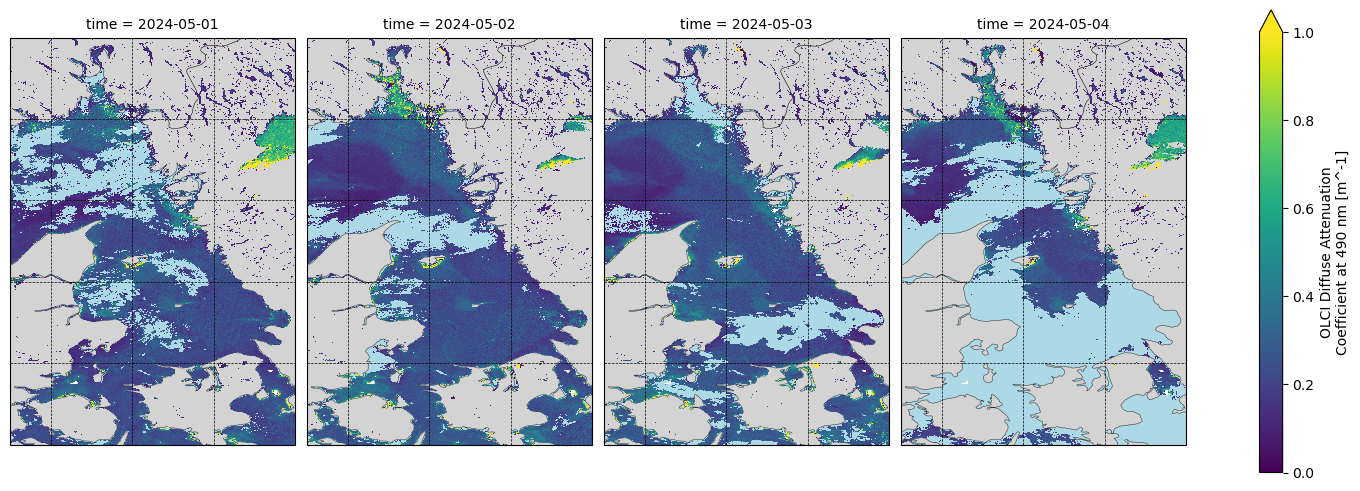

In [34]:
fig = ds.KD490.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    vmin=0, 
    vmax=1,
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-block alert-warning"> 
We now apply a forward filling technique to fill in data gaps caused by cloud cover. This takes the last valid pixel value and carries that data through in the time dimension. We limit the forward filling to 7 days to make sure that we are not looking at data outdated by more that a week. We then plot the first four days of data again to see the effect of the forward fill in comparison with the above maps which visualize the raw data. We now have a more complete dataset for K$_{d}$(490) over our entire time series.
</div>

In [8]:
ds_fill = ds.ffill(dim='time', limit=7)

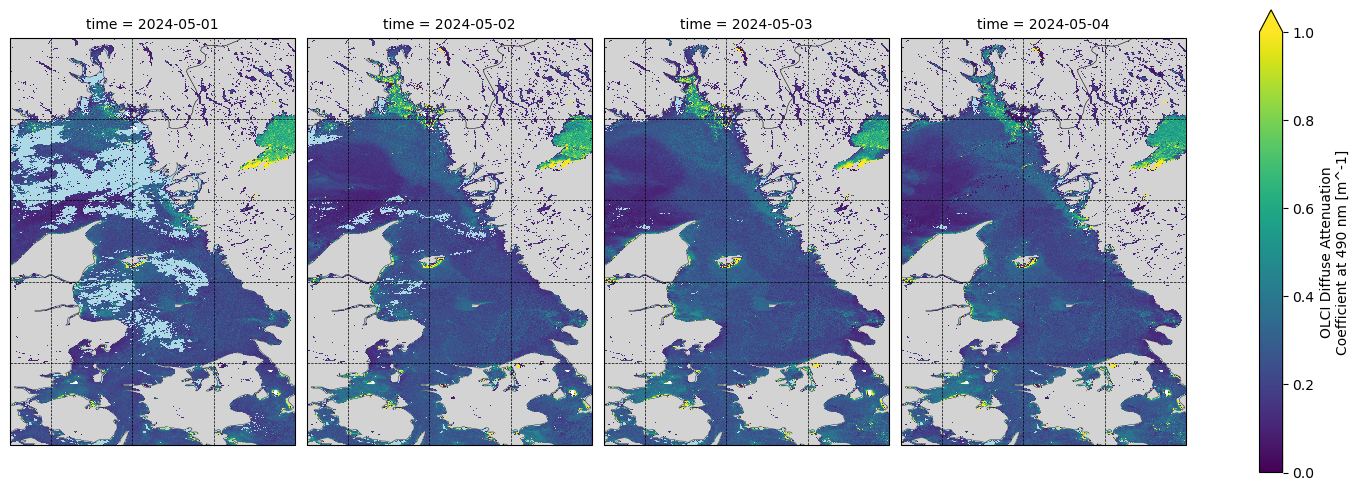

In [15]:
fig = ds_fill.KD490.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
#    col_wrap=3, 
    vmin=0, 
    vmax=1,
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-block alert-warning"> 
We can see that the image is filled in progressively with data from previous days. For example, in the forward filled dataset May 4th has values for almost our entire area of interest, whereas in the original dataset there were many gaps in the May 4th image.
</div>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>2. Calculating the Euphotic Depth
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
Our next step is to convert the diffuse attenuation coefficient of blue light (K$_{d}$(490)) to a more usable parameter - namely the penetration depth in meters of blue light. We do this using the following equation published in Kratzer et. al. 2003 that is based on in-situ data verification in the Baltic Sea:

Z$_{eu}$ = 6.8 * K${d}$(490)$^{-1}$

Where Z$_{eu}$ = Euphotic depth (the depth at which at least 1% of light penetrates the water column).

You can see in the following code that we create a new variable (Zeu_depth) to store the results of this equation, thus retaining our original data in the dataset. We take a look at the resulting dataset to make sure that Zeu_depth has indeed been added.
</div>

In [9]:
ds_fill = ds_fill.assign(Zeu_depth=6.8/(ds_fill['KD490']))
ds_fill

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 1856, longitude: 658, time: 153)
Coordinates:
  * latitude   (latitude) float32 7kB 55.0 55.0 55.01 55.01 ... 59.99 60.0 60.0
  * longitude  (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time       (time) datetime64[ns] 1kB 2024-05-01 2024-05-02 ... 2024-09-30
Data variables:
    KD490      (time, latitude, longitude) float32 747MB nan nan nan ... nan nan
    Zeu_depth  (time, latitude, longitude) float32 747MB nan nan nan ... nan nan
Attributes: (12/38)
    BALMLP_code_version:     BAL MLP ENSEMBLE 2021
    Conventions:             CF-1.4
    area:                    bal
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_NRT_009_131
    cmems_production_unit:   OC-CNR-ROMA-IT
    contact:                 technical@gos.artov.isac.cnr.it
    ...                      ...
    southernmost_latitude:   53.25
    start_date:              2023-04-18
    stop_date:               2023-04-18
    timeliness:              NR
    title:                   cmems_obs-oc_bal_bgc-transp_nrt_l3-olci-300m_P1D
    westernmost_longitude:   9.25

<div class="alert alert-block alert-warning"> 
We now visualize the euphotic depth for the first four days of our dataset on a scale of 0-100 meters.
</div>

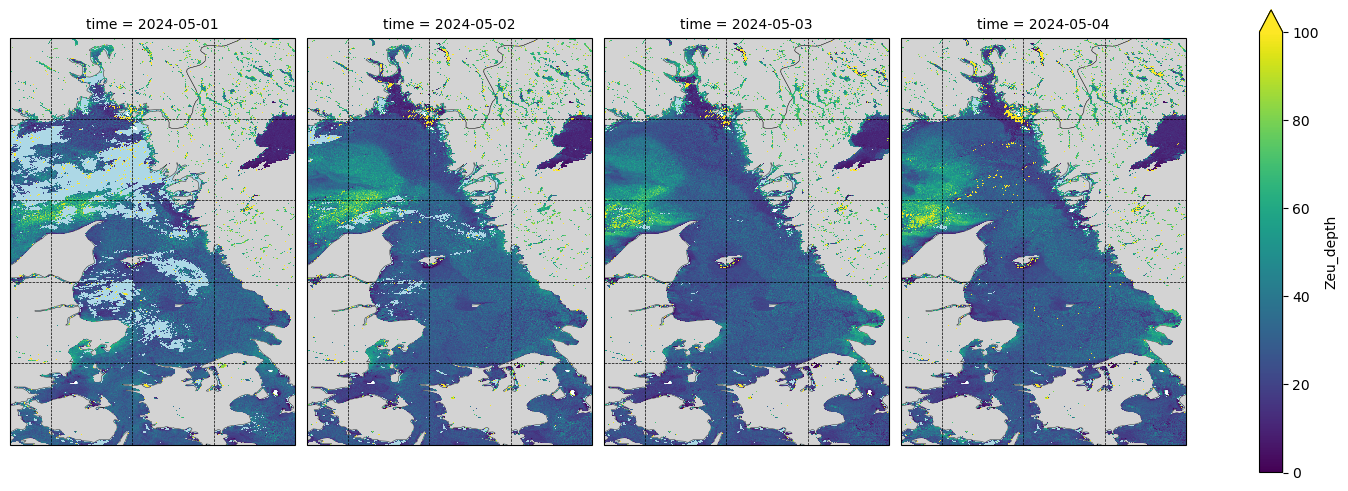

In [32]:
fig = ds_fill.Zeu_depth.isel(time=slice(0,4)).plot(
    transform=ccrs.PlateCarree(),
    col='time',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    vmin=0, 
    vmax=100,
    figsize=(15,5),
    zorder=2
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-info" role="alert">

## <a id='section1'></a>3. Bathymetry and the Euphotic Zone
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
Now that we have calculated the euphotic depth (i.e. the depth of at least 1% of blue light penetration in the water column), we can take our analysis further by determining where and how much of that light is actually incident on the seafloor. To do this we need to read in a bathymetry dataset, which is downloaded from EMODnet and provided with this repository.

In the following code we read in the bathymetry dataset, convert it into an xarray dataset, and take a look at both the dataset and the the resulting visualization.
</div>

In [10]:
# read in EMODnet bathymetry
bathy = os.path.join('external_data', 'Area of interest_220222.tif')

In [11]:
# Open into an xarray.DataArray
bathy_da = rioxarray.open_rasterio(bathy)

# invert height/depth - meters below sea level become positive
bathy_da = bathy_da*-1

# Covert our xarray.DataArray into a xarray.Dataset
bathy_ds = bathy_da.to_dataset('band')

# Rename the variable to a more useful name
bathy_ds = bathy_ds.rename({1: 'mbsl'})

# Slice in space
bathy_ds = bathy_ds.sel(y=slice(60,55), x=slice(9.5,13))
bathy_ds

<xarray.Dataset> Size: 16MB
Dimensions:      (y: 1957, x: 2006)
Coordinates:
  * x            (x) float64 16kB 10.04 10.04 10.04 10.04 ... 12.12 12.12 12.13
  * y            (y) float64 16kB 59.21 59.2 59.2 59.2 ... 57.17 57.17 57.17
    spatial_ref  int64 8B 0
Data variables:
    mbsl         (y, x) float32 16MB -170.1 -167.4 -160.7 ... 14.35 14.65 14.55

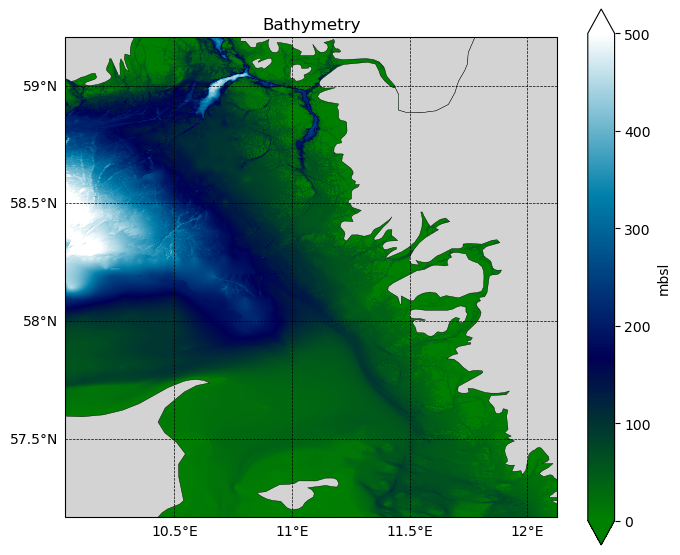

In [12]:
# plot bathymetry to check data
fig, axis = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection=ccrs.PlateCarree()))

bathy_ds.mbsl.plot(
    ax=axis,
    transform=ccrs.PlateCarree(),
    vmin=0, 
    vmax=500,
    cmap='ocean',
    cbar_kwargs={'orientation':'vertical', 'shrink':0.8},
)

axis.add_feature(land, zorder=1)

g1 = axis.gridlines(draw_labels=True, zorder=2, color='0.0', linestyle='--',linewidth=0.5)
g1.top_labels = False
g1.right_labels = False
g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 0.5))
g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 0.5))

axis.set_title('Bathymetry')
plt.tight_layout()

<div class="alert alert-block alert-warning"> 
Because the bathymetry dataset has a different spatial resolution and geographical area than our Copernicus Marine dataset, we need to reproject and resample one of the datasets to match the other. We choose here to reproject the bathymetry data and keep the cmems data at the same resolution it began with.

In the following code blocks we look at the "shape" of both datasets, reproject and resample the bathymetry dataset, and then join the bathymetry dataset to our cmems dataset so that we can do some further analysis!
</div>

In [12]:
# Create grid maps for both cmems dataset and bathymetry
ds_gm = GridMapping.from_dataset(ds_fill)
bathy_gm = GridMapping.from_dataset(bathy_ds)

# check grid coords for bathymetry
x_coords, y_coords = bathy_gm.xy_coords
y_coords

<xarray.DataArray 'xy_coords' (y: 1957, x: 2006)> Size: 31MB
dask.array<getitem, shape=(1957, 2006), dtype=float64, chunksize=(1957, 2006), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

In [13]:
x_coords, y_coords = ds_gm.xy_coords
y_coords

<xarray.DataArray 'xy_coords' (latitude: 1856, longitude: 658)> Size: 5MB
dask.array<getitem, shape=(1856, 658), dtype=float32, chunksize=(1856, 658), chunktype=numpy.ndarray>
Dimensions without coordinates: latitude, longitude

In [14]:
# Reproject bathy to cmems resolution and gridding
bathy_re = resample_in_space(bathy_ds, source_gm=bathy_gm, target_gm=ds_gm)

# check bathy grid map to make sure it matches cmems dataset
bathy_gm1 = GridMapping.from_dataset(bathy_re)
x_coords, y_coords = bathy_gm1.xy_coords
y_coords

<xarray.DataArray 'xy_coords' (y: 1856, x: 658)> Size: 10MB
dask.array<getitem, shape=(1856, 658), dtype=float64, chunksize=(1856, 658), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

In [15]:
# fix bathymetry lat/long coords to match cmems before joining into a new dataset
bathy_re = bathy_re.rename({'x': 'longitude','y': 'latitude'})
bathy_re['latitude'] = ds_fill['latitude']
bathy_re['longitude'] = ds_fill['longitude']

In [16]:
# combine bathy and cmems to single dataset
comb1 = [[ds_fill],[bathy_re]]
comb1 = xr.combine_nested(comb1, concat_dim=[None,None], coords=['latitude','longitude'])
comb1

<xarray.Dataset> Size: 1GB
Dimensions:      (latitude: 1856, longitude: 658, time: 153)
Coordinates:
  * latitude     (latitude) float32 7kB 55.0 55.0 55.01 ... 59.99 60.0 60.0
  * longitude    (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time         (time) datetime64[ns] 1kB 2024-05-01 2024-05-02 ... 2024-09-30
    spatial_ref  int64 8B 0
Data variables:
    KD490        (time, latitude, longitude) float32 747MB nan nan ... nan nan
    Zeu_depth    (time, latitude, longitude) float32 747MB nan nan ... nan nan
    mbsl         (latitude, longitude) float32 5MB dask.array<chunksize=(1856, 658), meta=np.ndarray>
    crs          int64 8B 0

<div class="alert alert-block alert-warning"> 
We now have a dataset called "comb1" that includes data variable for our original K$_{d}$(490) data, Euphotic depth, and a variable named "mbls" (meters below sea level).
</div>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>4. Calculating Seafloor Light Properties
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
We are now ready to analyse the light penetration depth together with our bathymetry dataset in order to determine both where light reaches the seafloor, as well as how much of the light incident on the water surface reaches the seafloor.

The resulting dataset <strong>"Zeu_ds"</strong> includes two new variables:
* <strong>Zeu_zone</strong> = a binary variable showing pixels where at least 1% of light reaches the seafloor
* <strong>Zeu_percent</strong> = a variable that show what percentage of light incident on the water surface reaches the seafloor
</div>

In [17]:
# calculate new variable for euphotic zone
## Zeu_norm is the theoretical penetration of light BELOW the ocean bottom, if positive (+) this cell is part of the Zeu
comb1 = comb1.assign(Zeu_norm=comb1['Zeu_depth']-comb1['mbsl'])

# Calculate % of light incident on water surface that reaches the seafloor
comb1 = comb1.assign(Zeu_percent=(((comb1['Zeu_norm']) / (comb1['Zeu_depth']))*100))
comb1 = comb1.transpose('time',...)

# Create a new dataset that is limited to pixels where at least 1% of light reaches the seafloor
Zeu_norm = comb1.Zeu_norm
Zeu_per = comb1.Zeu_percent
Zeu = xr.combine_by_coords([Zeu_norm, Zeu_per], compat='broadcast_equals')
Zeu = Zeu.where(Zeu.Zeu_percent >= 1)

# Create a binary variable to include in the dataset
Zeu_zone = Zeu.Zeu_percent
Zeu_zone = Zeu_zone.rename('Zeu_zone').to_dataset()
#Zeu_zone = xr.where(Zeu_zone >= 1, 1, np.nan).to_dataset()

Zeu_zone = xr.where(Zeu_zone.Zeu_zone >= 1, 1, xr.where(Zeu_zone.Zeu_zone < 1, np.nan, np.nan)).to_dataset()
Zeu = xr.combine_by_coords([Zeu, Zeu_zone], compat='broadcast_equals')

# Drop unnecessary variable and combine our new dataset with our original dataset
comb2 = comb1.drop_vars(['Zeu_norm', 'Zeu_percent'])
Zeu = Zeu.drop_vars(['Zeu_norm'])
Zeu_ds = xr.combine_by_coords([comb2, Zeu], compat='broadcast_equals')

Zeu_ds

<xarray.Dataset> Size: 4GB
Dimensions:      (latitude: 1856, longitude: 658, time: 153)
Coordinates:
  * latitude     (latitude) float32 7kB 55.0 55.0 55.01 ... 59.99 60.0 60.0
  * longitude    (longitude) float32 3kB 9.503 9.508 9.513 ... 12.99 12.99 13.0
  * time         (time) datetime64[ns] 1kB 2024-05-01 2024-05-02 ... 2024-09-30
    spatial_ref  int64 8B 0
Data variables:
    KD490        (time, latitude, longitude) float32 747MB nan nan ... nan nan
    Zeu_depth    (time, latitude, longitude) float32 747MB nan nan ... nan nan
    mbsl         (latitude, longitude) float32 5MB dask.array<chunksize=(1856, 658), meta=np.ndarray>
    crs          int64 8B 0
    Zeu_percent  (time, latitude, longitude) float32 747MB dask.array<chunksize=(153, 1856, 658), meta=np.ndarray>
    Zeu_zone     (time, latitude, longitude) float64 1GB dask.array<chunksize=(153, 1856, 658), meta=np.ndarray>

<div class="alert alert-block alert-warning"> 
In the following code cell we crop our dataset to a smaller area of interest. If you would like to change the area of interest please adjust the min/max lat/long variable in the following code block.
</div>

In [18]:
# Crop Zeu to a smaller area of interest
min_lon = 10.1
min_lat = 57.3
max_lon = 12 
max_lat = 59.2

Zeu_crop = Zeu_ds.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))

<div class="alert alert-block alert-warning"> 
Here we visualize the binary euphotic zone for a single data from our time series. If you would like to investigate a different day can you adjust the "date_index" variable, where 0 is the first day of the dataset, and -1 is the last day.
</div>

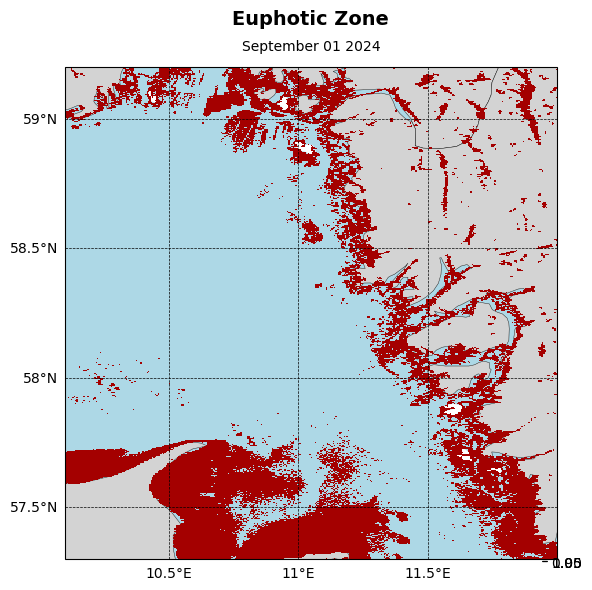

In [22]:
# Insert index for which day to investigate the Euphotic Zone

date_index = -30

fig, axis = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection=ccrs.PlateCarree()))

plot = Zeu_crop.Zeu_zone.isel(time=[date_index]).plot(
    ax=axis,
    transform=ccrs.PlateCarree(),
    zorder=2,
    cmap='flag',
#    cbar.ax.tick_params(labelsize=0),
    cbar_kwargs={'orientation':None, 'label':'','ticks':None,'shrink':0.0, 'anchor':(-0.5,0.11)}
)

axis.add_feature(land, zorder=1)
axis.add_feature(ocean,zorder=0)

g1 = axis.gridlines(draw_labels=True, zorder=2, color='0.0', linestyle='--',linewidth=0.5)
g1.top_labels = False
g1.right_labels = False
g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 0.5))
g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 0.5))

date=Zeu_crop['time'].dt.strftime("%B %d %Y")
date=date.to_numpy()


#plt.title('2024-09-16', fontsize=10, pad=12)
plt.title(date[date_index], fontsize=10, pad=12)

plt.suptitle('Euphotic Zone', y=0.91, x=0.45, fontsize=14, fontweight='bold')

plt.tight_layout()

<div class="alert alert-info" role="alert">

## <a id='section1'></a>5. Averaging Data With Different Time Steps
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning"> 
Now that we have created a complete dataset with daily data, we can average the data with different time steps. For many purposes, a daily dataset of the ocean light environment is too detailed. We may prefer to average the dataset weekly, monthly, or over the entire dataset loaded in the beginning of this notebook.

In the following cell we resample the daily dataset to a weekly time step. You can see in the resulting dataset that we now have a "week" dimension covering 23 weeks between May and September.
</div>

In [19]:
Zeu_week_ds = Zeu_crop.groupby('time.week').mean()
Zeu_week_ds

<xarray.Dataset> Size: 139MB
Dimensions:      (week: 23, latitude: 705, longitude: 357)
Coordinates:
  * latitude     (latitude) float32 3kB 57.3 57.3 57.31 ... 59.19 59.2 59.2
  * longitude    (longitude) float32 1kB 10.1 10.11 10.11 ... 11.99 11.99 12.0
    spatial_ref  int64 8B 0
  * week         (week) int64 184B 18 19 20 21 22 23 24 ... 34 35 36 37 38 39 40
Data variables:
    KD490        (week, latitude, longitude) float32 23MB nan nan ... nan nan
    Zeu_depth    (week, latitude, longitude) float32 23MB nan nan ... nan nan
    mbsl         (week, latitude, longitude) float32 23MB dask.array<chunksize=(1, 705, 357), meta=np.ndarray>
    crs          (week) float64 184B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Zeu_percent  (week, latitude, longitude) float32 23MB dask.array<chunksize=(1, 705, 357), meta=np.ndarray>
    Zeu_zone     (week, latitude, longitude) float64 46MB dask.array<chunksize=(1, 705, 357), meta=np.ndarray>

<div class="alert alert-block alert-warning"> 
We can now visualize the percentage of light incident on the seafloor at the weekly time resolution. Here we step through 6 weeks in the middle of our time series to show how the light properties at the seabed change during the summer season. Please note that the Week # titles are note week numbers in the year, but rather that week's index from the start of the dataset.
</div>

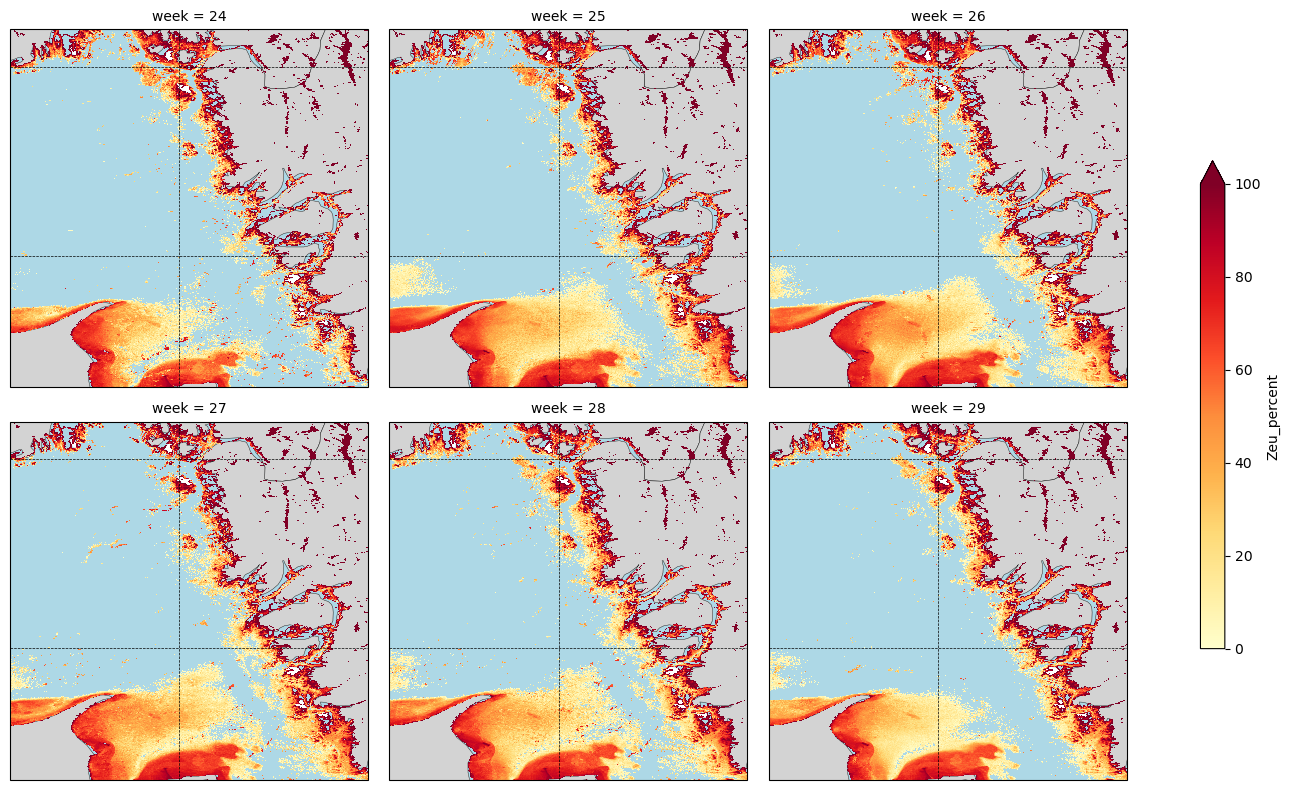

In [25]:
## Plot the first 6 days of the euphotic zone time series for a visual inspection
fig = Zeu_week_ds.Zeu_percent.isel(week=slice(-17,-11)).plot(
    transform=ccrs.PlateCarree(),
    col='week',
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col_wrap=3, 
    vmin=0, 
    vmax=100,
    figsize=(15,8),
    zorder=2,
    cmap='YlOrRd',
    cbar_kwargs={'orientation':'vertical', 'shrink':0.65}
)

[ax.add_feature(land,zorder=1) for ax in fig.axs.flatten()]
[ax.add_feature(ocean,zorder=0) for ax in fig.axs.flatten()]

for ax in fig.axs.flat:
    g1 = ax.gridlines(color='black', linewidth=0.5, linestyle='--')
    g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 1))
    g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 1))

<div class="alert alert-block alert-warning"> 
We will now average the entire time series along the time dimension, collapsing all of our data variables to a single average value at each pixel from all days. In the resulting dataset you can see that the "time" dimension has been removed. If you would like to investigate the averaged data over a different time period you can adjust the initial data that is loaded in from Copernicus Marine, or take a time slice of this dataset.

In the following cell we visualize the percent of light incident on the seafloor averaged over the entire summer season.
</div>

In [20]:
Zeu_mean_ds = Zeu_crop.mean(dim='time', skipna=True)
Zeu_mean_ds

<xarray.Dataset> Size: 6MB
Dimensions:      (latitude: 705, longitude: 357)
Coordinates:
  * latitude     (latitude) float32 3kB 57.3 57.3 57.31 ... 59.19 59.2 59.2
  * longitude    (longitude) float32 1kB 10.1 10.11 10.11 ... 11.99 11.99 12.0
    spatial_ref  int64 8B 0
Data variables:
    KD490        (latitude, longitude) float32 1MB nan nan nan ... nan nan nan
    Zeu_depth    (latitude, longitude) float32 1MB nan nan nan ... nan nan nan
    mbsl         (latitude, longitude) float32 1MB dask.array<chunksize=(705, 357), meta=np.ndarray>
    crs          float64 8B 0.0
    Zeu_percent  (latitude, longitude) float32 1MB dask.array<chunksize=(705, 357), meta=np.ndarray>
    Zeu_zone     (latitude, longitude) float64 2MB dask.array<chunksize=(705, 357), meta=np.ndarray>

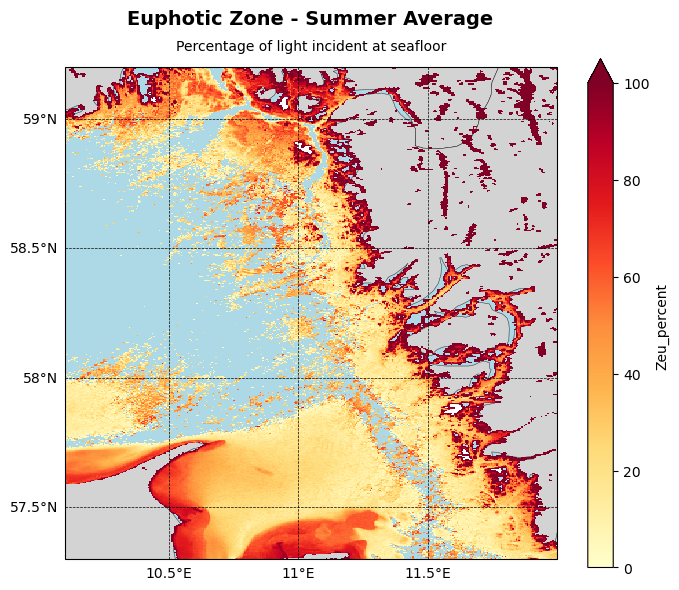

In [27]:
fig, axis = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection=ccrs.PlateCarree()))

plot = Zeu_mean_ds.Zeu_percent.plot(
    ax=axis,
    transform=ccrs.PlateCarree(),
    vmin=0, 
    vmax=100,
    zorder=2,
    cmap='YlOrRd',
    cbar_kwargs={'orientation':'vertical','shrink':0.8},
)

axis.add_feature(land, zorder=1)
axis.add_feature(ocean,zorder=0)

g1 = axis.gridlines(draw_labels=True, zorder=2, color='0.0', linestyle='--',linewidth=0.5)
g1.top_labels = False
g1.right_labels = False
g1.xlocator = mticker.FixedLocator(np.arange(10, 14, 0.5))
g1.ylocator = mticker.FixedLocator(np.arange(55, 60, 0.5))

plt.title('Percentage of light incident at seafloor', fontsize=10, pad=12)
plt.suptitle('Euphotic Zone - Summer Average', y=0.91, x=0.45, fontsize=14, fontweight='bold')

plt.tight_layout()

<div class="alert alert-block alert-warning"> 
Finally, we will use the xcube Viewer library to create an interactive map displaying data from our daily dataset. This map instance will be deployed Wekeo's server instance and requires the user to input their Wekeo username in the following cell in the variable "usernm"

In the following cell we start the xcube viewer instance, followed by a cell where we specify the symbology for each of our data variables. In the final cell we start up the map viewer. In the viewer the user can select the variable to display from the dropdown list, step or play through the time series, zoom in, swipe between two different variables, and select a pixel to investigate the values at that location.
</div>

In [ ]:
# Import libraries for xcube Viewer
import os

usernm = 'username'

from xcube.webapi.viewer import Viewer 
os.environ["XCUBE_JUPYTER_LAB_URL"] = "https://jupyterhub.prod.wekeo2.eu/user/" + usernm + "/"

In [22]:
# set styles and initialize Viewer object
## need to work on styles!
viewer = Viewer(server_config={
#    "port": 9002,
    "Styles": [
        {
            "Identifier": "pz",
            "ColorMappings": {
                "KD490": {
                    "ValueRange": [0, 1],
                    "ColorBar": "viridis"},
                "Zeu": {
                    "ValueRange": [0, 100],
                    "ColorBar": "viridis"},               
                "Zeu_binary": {
                    "ValueRange": [1, 1],
                    "ColorBar": "Set1"},
                "Zeu_percent": {
                    "ValueRange": [0, 100],
                    "ColorBar": "thermal"},
                "mbsl": {
                    "ValueRange": [0, 500],
                    "ColorBar": "ocean"
                },
            }
        }
    ]
})

404 GET /viewer/config/config.json (127.0.0.1): xcube viewer has not been been configured
404 GET /viewer/config/config.json (127.0.0.1) 37.00ms
501 GET /viewer/state?key=sentinel (127.0.0.1) 0.42ms
404 GET /viewer/ext/contributions (127.0.0.1) 0.56ms
no chunks found for dimension 'time' of variable 'KD490' in time-chunked dataset '6efc090f-8695-4a87-8d2e-125fd7a30d46'
no chunks found for dimension 'time' of variable 'Zeu_depth' in time-chunked dataset '6efc090f-8695-4a87-8d2e-125fd7a30d46'
no chunks found for dimension 'time' of variable 'mbsl' in time-chunked dataset '6efc090f-8695-4a87-8d2e-125fd7a30d46'
no chunks found for dimension 'time' of variable 'Zeu_percent' in time-chunked dataset '6efc090f-8695-4a87-8d2e-125fd7a30d46'
no chunks found for dimension 'time' of variable 'Zeu_zone' in time-chunked dataset '6efc090f-8695-4a87-8d2e-125fd7a30d46'


In [23]:
# replace "dsview" with dataset to visualize
dsview = Zeu_ds

viewer.add_dataset(dsview, style="pz")

viewer.show()